# 2048 DQN 모델 학습

## 학습 계획
- **목적**: 2048 게임에서 고득점을 달성하는 CNN 기반 DQN 에이전트 학습
- **아키텍처**: CNN (Layered)
- **환경**: Google Colab GPU 사용

## 환경 설정

In [ ]:
# 필요한 패키지 설치
!pip install torch torchvision gym matplotlib seaborn tensorboard
!pip install onnx onnxruntime

import torch
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

## 코드 업로드 및 설정

In [ ]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

import sys
import os

# 프로젝트 경로 설정
PROJECT_ROOT = '/content/drive/MyDrive/2048-rl-project'
TRAINING_PATH = os.path.join(PROJECT_ROOT, 'training')

# Python 경로에 추가
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
if TRAINING_PATH not in sys.path:
    sys.path.insert(0, TRAINING_PATH)

# 작업 디렉토리 변경
os.chdir(TRAINING_PATH)

print(f"✅ 경로 설정 완료!")
print(f"  프로젝트 루트: {PROJECT_ROOT}")
print(f"  학습 경로: {TRAINING_PATH}")
print(f"  현재 작업 디렉토리: {os.getcwd()}")

Mounted at /content/drive
✅ 경로 설정 완료!
  프로젝트 루트: /content/drive/MyDrive/2048-rl-project
  학습 경로: /content/drive/MyDrive/2048-rl-project/training
  현재 작업 디렉토리: /content/drive/MyDrive/2048-rl-project/training


## 모델 및 환경 불러오기

In [ ]:
# 모듈 import 및 테스트
print("🔄 모듈 로딩 시작...")

from environment.game_2048 import Game2048Env
from models.dqn_agent import DQNAgent
from models.networks import count_parameters

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output
import pandas as pd

print("✅ 모듈 로드 완료")

🔄 모듈 로딩 시작...
✅ Environment 패키지 로드 완료 - 지원 관찰 타입: ['layered']
✅ Models 패키지 로드 완료 - 지원 네트워크: ['layered']
✅ 모듈 로드 완료


## 학습 설정

In [ ]:
TRAINING_CONFIG = {
    # 기본 설정
    'episodes': 2000,
    'max_steps_per_episode': 1000,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # DQN 설정
    'buffer_size': 100000,
    'batch_size': 64,
    'lr': 1e-4,
    'gamma': 0.99,
    'epsilon_start': 0.9,
    'epsilon_end': 0.01,
    'epsilon_decay': 30000,
    'target_update': 1000,

    # 평가 및 로깅 설정
    'eval_interval': 100,
    'eval_episodes': 10,
    'save_interval': 500,
    'plot_interval': 50,
    'log_interval': 10
}

print("⚙️ 학습 설정 완료:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

⚙️ 학습 설정 완료:
  episodes: 2000
  max_steps_per_episode: 1000
  device: cuda
  buffer_size: 100000
  batch_size: 64
  lr: 0.0001
  gamma: 0.99
  epsilon_start: 1.0
  epsilon_end: 0.01
  epsilon_decay: 50000
  target_update: 1000
  eval_interval: 100
  eval_episodes: 10
  save_interval: 500
  plot_interval: 50
  log_interval: 10


## 모델 초기화

In [ ]:
# 개선된 에이전트 생성 함수
def create_agent_and_env():
    """개선된 에이전트와 환경 생성"""
    env = Game2048Env()

    agent = DQNAgent(
        lr=TRAINING_CONFIG['lr'],
        gamma=TRAINING_CONFIG['gamma'],
        epsilon_start=TRAINING_CONFIG['epsilon_start'],
        epsilon_end=TRAINING_CONFIG['epsilon_end'],
        epsilon_decay=TRAINING_CONFIG['epsilon_decay'],
        buffer_size=TRAINING_CONFIG['buffer_size'],
        batch_size=TRAINING_CONFIG['batch_size'],
        target_update=TRAINING_CONFIG['target_update'],
        double_dqn=True,           # Double DQN 활성화
        dueling=False,             # 안정성을 위해 처음엔 False
        prioritized_replay=True,   # 성능 향상
        device=TRAINING_CONFIG['device']
    )

    return agent, env

print("🧠 CNN 에이전트 생성...")
agent, env = create_agent_and_env()
print(f"📊 모델 파라미터: {count_parameters(agent.q_network):,}")

🧠 CNN 에이전트 생성...
🤖 DQN Agent 초기화 - Device: cuda
🤖 DQN Agent 초기화 완료
   - Double DQN: True
   - Dueling DQN: False
   - Prioritized Replay: True
📊 모델 파라미터: 1,628,292


## 학습 모니터링 함수

In [ ]:
class TrainingMonitor:
    def __init__(self):
        self.reset()

    def reset(self):
        self.episode_rewards = []
        self.episode_scores = []
        self.episode_steps = []
        self.episode_losses = []
        self.highest_tiles = []
        self.eval_scores = []
        self.eval_episodes = []

    def add_episode(self, reward, score, steps, loss, highest_tile):
        self.episode_rewards.append(reward)
        self.episode_scores.append(score)
        self.episode_steps.append(steps)
        self.episode_losses.append(loss)
        self.highest_tiles.append(highest_tile)

    def add_eval(self, episode, avg_score):
        self.eval_episodes.append(episode)
        self.eval_scores.append(avg_score)

    def plot_progress(self, title="Training Progress"):
        if len(self.episode_rewards) < 10:
            return

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(title, fontsize=16)

        # 보상
        axes[0,0].plot(self.episode_rewards, alpha=0.3, color='blue')
        axes[0,0].plot(pd.Series(self.episode_rewards).rolling(50).mean(), color='red')
        axes[0,0].set_title('Episode Rewards')
        axes[0,0].set_ylabel('Reward')

        # 점수
        axes[0,1].plot(self.episode_scores, alpha=0.3, color='green')
        axes[0,1].plot(pd.Series(self.episode_scores).rolling(50).mean(), color='red')
        axes[0,1].set_title('Episode Scores')
        axes[0,1].set_ylabel('Score')

        # 최고 타일
        axes[0,2].plot(self.highest_tiles, alpha=0.3, color='purple')
        axes[0,2].plot(pd.Series(self.highest_tiles).rolling(50).mean(), color='red')
        axes[0,2].set_title('Highest Tiles')
        axes[0,2].set_ylabel('Tile Value')

        # 스텝 수
        axes[1,0].plot(self.episode_steps, alpha=0.3, color='orange')
        axes[1,0].plot(pd.Series(self.episode_steps).rolling(50).mean(), color='red')
        axes[1,0].set_title('Episode Steps')
        axes[1,0].set_ylabel('Steps')
        axes[1,0].set_xlabel('Episode')

        # 손실
        if self.episode_losses and any(loss is not None for loss in self.episode_losses):
            valid_losses = [l for l in self.episode_losses if l is not None]
            if valid_losses:
                axes[1,1].plot(valid_losses, alpha=0.3, color='red')
                axes[1,1].plot(pd.Series(valid_losses).rolling(20).mean(), color='darkred')
        axes[1,1].set_title('Training Loss')
        axes[1,1].set_ylabel('Loss')
        axes[1,1].set_xlabel('Episode')

        # 평가 점수
        if self.eval_scores:
            axes[1,2].plot(self.eval_episodes, self.eval_scores, 'o-', color='darkgreen')
        axes[1,2].set_title('Evaluation Scores')
        axes[1,2].set_ylabel('Avg Score')
        axes[1,2].set_xlabel('Episode')

        plt.tight_layout()
        plt.show()

    def get_stats(self):
        if not self.episode_scores:
            return {}

        recent_scores = self.episode_scores[-100:]
        recent_tiles = self.highest_tiles[-100:]

        return {
            'episodes': len(self.episode_scores),
            'avg_score': np.mean(recent_scores),
            'max_score': max(self.episode_scores),
            'avg_highest_tile': np.mean(recent_tiles),
            'max_highest_tile': max(self.highest_tiles),
            'avg_steps': np.mean(self.episode_steps[-100:])
        }

monitor = TrainingMonitor()
print("📊 학습 모니터링 시스템 준비 완료!")

📊 학습 모니터링 시스템 준비 완료!


## 학습 함수

In [ ]:
def evaluate_agent(agent, env, num_episodes=5):
    """액션 마스킹이 적용된 에이전트 평가 함수"""
    total_scores = []
    total_steps = []
    highest_tiles = []
    
    for _ in range(num_episodes):
        state = env.reset()
        steps = 0
        while steps < 1000:
            # 🔥 액션 마스킹 적용
            valid_actions = env.get_valid_actions()
            if not valid_actions:  # 게임 종료 (안전장치)
                break
                
            action = agent.select_action(state, training=False, valid_actions=valid_actions)
            next_state, _, done, info = env.step(action)
            state = next_state
            steps += 1
            
            if done:
                total_scores.append(info['score'])
                total_steps.append(steps)
                highest_tiles.append(info['highest'])
                break
    
    return {
        'avg_score': np.mean(total_scores) if total_scores else 0,
        'avg_steps': np.mean(total_steps) if total_steps else 0,
        'avg_highest': np.mean(highest_tiles) if highest_tiles else 0,
        'max_score': max(total_scores) if total_scores else 0,
        'max_highest': max(highest_tiles) if highest_tiles else 0
    }

def train_agent(agent, env, monitor, episodes):
    """액션 마스킹이 적용된 에이전트 학습 함수 (수정된 버전)"""
    print(f"🚀 액션 마스킹 적용 CNN 모델 학습 시작! (목표: {episodes} 에피소드)")
    start_time = time.time()
    best_score = 0
    best_highest = 0

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        episode_losses = []
        final_info = {'score': 0, 'highest': 0, 'valid_actions': []}  # 기본값 설정

        while steps < TRAINING_CONFIG['max_steps_per_episode']:
            # 🔥 액션 마스킹 적용
            valid_actions = env.get_valid_actions()
            
            # 유효한 액션이 없으면 게임 종료
            if not valid_actions:
                print(f"⚠️ Episode {episode+1}: No valid actions available at step {steps}")
                break
            
            # 액션 선택 (유효한 액션만 고려)
            action = agent.select_action(state, training=True, valid_actions=valid_actions)
            
            # 환경에서 액션 실행
            next_state, reward, done, info = env.step(action)
            final_info = info  # 마지막 info 저장
            
            # 경험 저장
            if hasattr(agent, 'prioritized_replay') and agent.prioritized_replay and agent.memory.is_ready(agent.batch_size):
                # TD error 미리 계산
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(agent.device)
                    current_q = agent.q_network(state_tensor)[0][action]
                    next_q = agent.target_network(next_state_tensor).max(1)[0]
                    target_q = reward + (agent.gamma * next_q * (not done))
                    td_error = abs((target_q - current_q).item())
                    agent.store_experience(state, action, reward, next_state, done, td_error)
            else:
                agent.store_experience(state, action, reward, next_state, done)

            # 학습 수행
            if agent.memory.is_ready(agent.batch_size):
                loss = agent.train_step()
                if loss is not None:
                    episode_losses.append(loss)

            state = next_state
            total_reward += reward
            steps += 1
            
            if done:
                break

        # 에피소드 통계 업데이트
        avg_loss = np.mean(episode_losses) if episode_losses else None
        monitor.add_episode(total_reward, final_info['score'], steps, avg_loss, final_info['highest'])
        agent.episode_rewards.append(total_reward)

        # 최고 기록 갱신
        if final_info['score'] > best_score:
            best_score = final_info['score']
            agent.save_model(f'/content/drive/MyDrive/2048_models/cnn_model_best_score.pth')
            
        if final_info['highest'] > best_highest:
            best_highest = final_info['highest']
            agent.save_model(f'/content/drive/MyDrive/2048_models/cnn_model_best_tile.pth')

        # 주기적 로깅
        if (episode + 1) % TRAINING_CONFIG['log_interval'] == 0:
            stats = agent.get_stats()
            elapsed = time.time() - start_time
            loss_str = f"{avg_loss:.4f}" if avg_loss is not None else "N/A"
            
            print(f"Episode {episode+1:4d} | Score: {final_info['score']:5.0f} | Highest: {final_info['highest']:4.0f} | "
                  f"Reward: {total_reward:7.2f} | Steps: {steps:3d} | Valid: {len(final_info['valid_actions'])} | "
                  f"ε: {stats['epsilon']:.3f} | Loss: {loss_str} | Time: {elapsed/60:.1f}min")
            
        if (episode + 1) % TRAINING_CONFIG['eval_interval'] == 0:
            eval_results = evaluate_agent(agent, env, TRAINING_CONFIG['eval_episodes'])
            monitor.add_eval(episode + 1, eval_results['avg_score'])
            
            print(f"🎯 평가 결과 (Episode {episode+1}):")
            print(f"   평균 점수: {eval_results['avg_score']:.1f}")
            print(f"   최고 점수: {eval_results['max_score']:.0f}")
            print(f"   평균 최고타일: {eval_results['avg_highest']:.0f}")
            print(f"   최고 타일: {eval_results['max_highest']:.0f}")

        # 주기적 시각화
        if (episode + 1) % TRAINING_CONFIG['plot_interval'] == 0:
            clear_output(wait=True)
            monitor.plot_progress(f"액션 마스킹 적용 CNN Training Progress - Episode {episode+1}")
            
            stats = monitor.get_stats()
            print(f"📊 현재 통계 (최근 100 에피소드):")
            for key, value in stats.items():
                if isinstance(value, float):
                    print(f"  {key}: {value:.2f}")
                else:
                    print(f"  {key}: {value}")
            
            # 액션 마스킹 효과 표시
            print(f"\n🎭 액션 마스킹 효과:")
            print(f"  현재 epsilon: {agent.get_epsilon():.4f}")
            print(f"  메모리 사용량: {len(agent.memory):,}/{agent.memory.capacity:,}")

        # 주기적 모델 저장
        if (episode + 1) % TRAINING_CONFIG['save_interval'] == 0:
            agent.save_model(f'/content/drive/MyDrive/2048_models/cnn_checkpoint_{episode+1}.pth')

    # 최종 모델 저장
    agent.save_model(f'/content/drive/MyDrive/2048_models/cnn_final_action_masked.pth')
    
    print(f"\n✅ 액션 마스킹 적용 학습 완료!")
    print(f"🏆 최고 점수: {best_score}")
    print(f"🎯 최고 타일: {best_highest}")
    
    return monitor

🔧 학습 함수 로드 완료!


## CNN 모델 학습

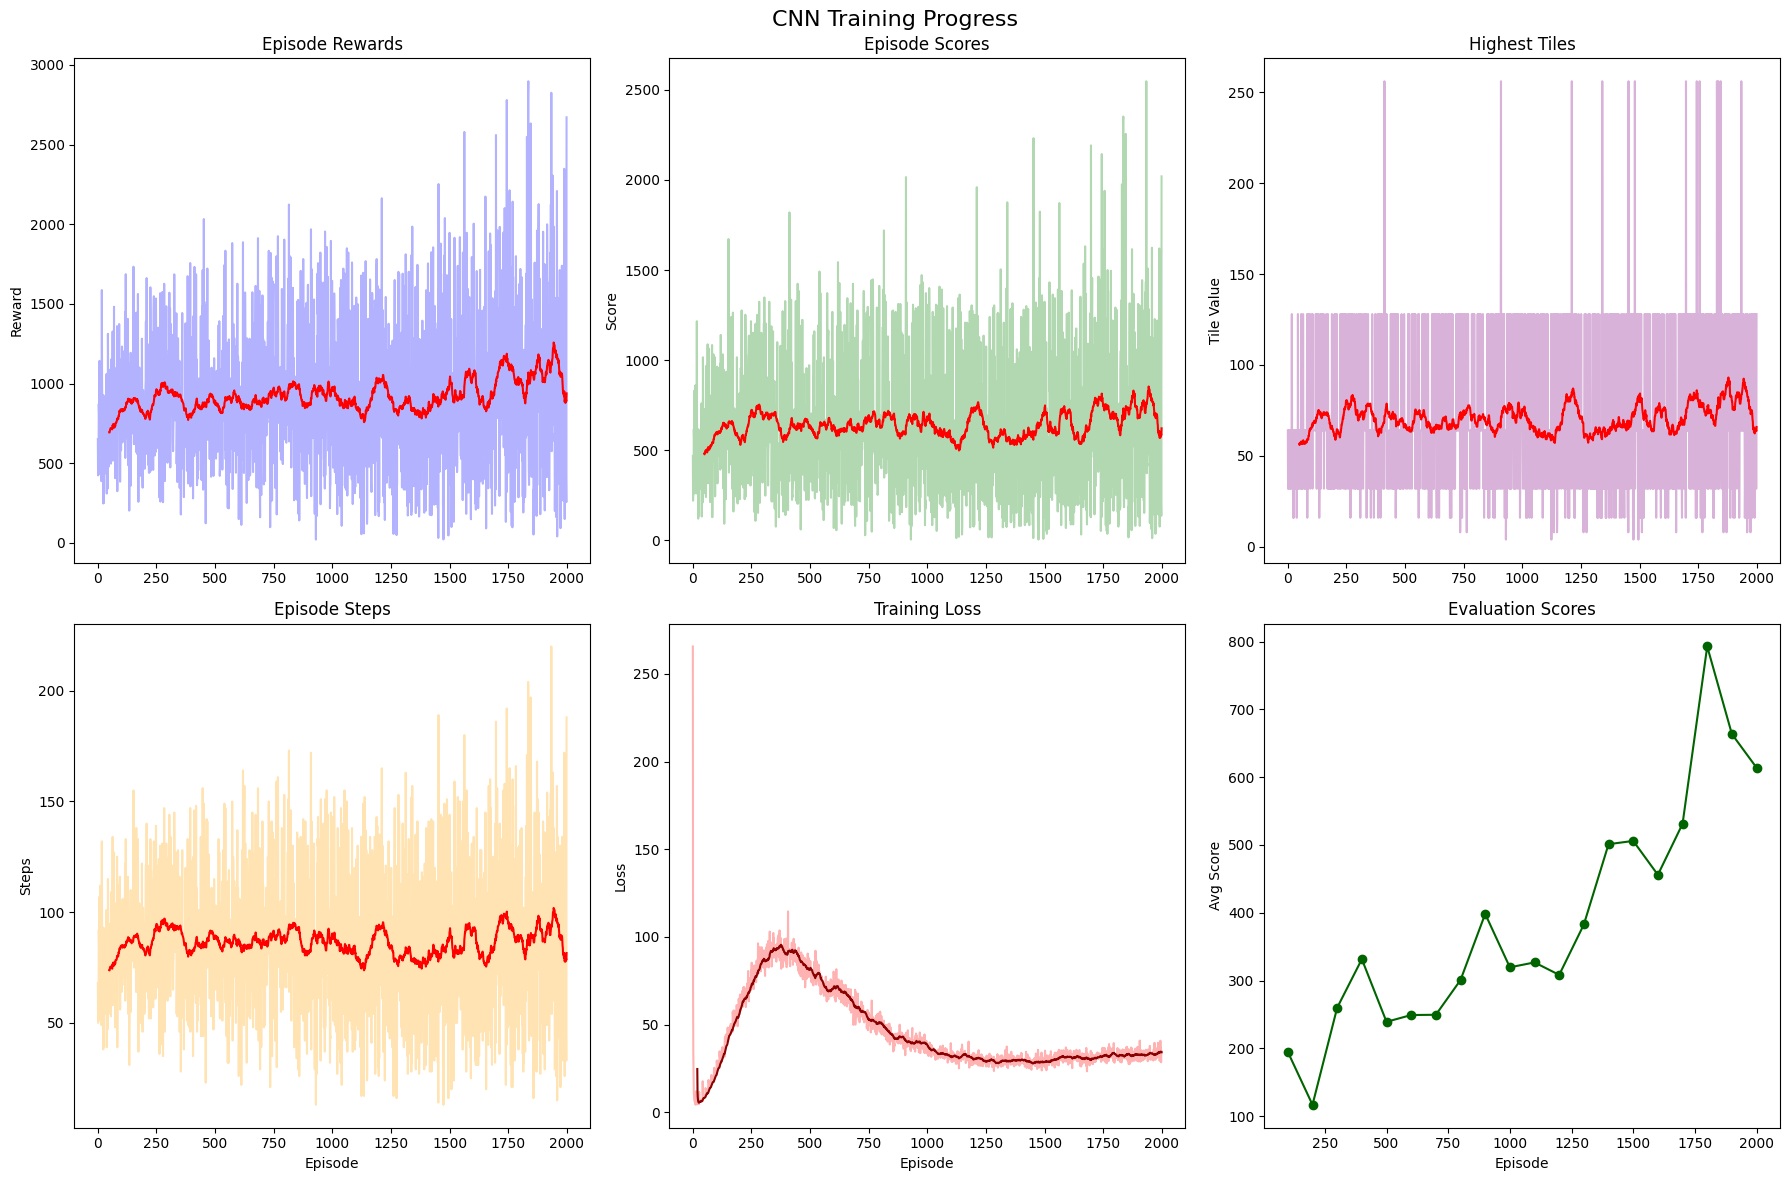

📊 현재 통계:
  episodes: 2000
  avg_score: 716.32
  max_score: 2548
  avg_highest_tile: 77.12
  max_highest_tile: 256
  avg_steps: 90.04
💾 모델 저장 완료: /content/drive/MyDrive/2048_models/cnn_checkpoint_2000.pth
💾 모델 저장 완료: /content/drive/MyDrive/2048_models/cnn_final.pth
✅ 학습 완료!


In [ ]:
monitor = train_agent(
    agent=agent,
    env=env,
    monitor=monitor,
    episodes=TRAINING_CONFIG['episodes']
)

## 🏆 최종 성능 평가

In [ ]:
print("🏆 최종 성능 평가 (50 게임)")
final_results = evaluate_agent(agent, env, 50)
print(f"📊 최종 평균 점수: {final_results['avg_score']:.1f}")
print(f"🏆 최고 점수: {final_results['max_score']:.0f}")
print(f"🎯 평균 최고 타일: {final_results['avg_highest']:.0f}")
print(f"🌟 최고 타일: {final_results['max_highest']:.0f}")

stats = monitor.get_stats()
print("\n📈 최종 학습 통계:")
for key, value in stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")

🏆 최종 성능 평가 (50 게임)
📊 최종 평균 점수: 572.4
📈 최종 학습 통계:
  episodes: 2000
  avg_score: 716.32
  max_score: 2548
  avg_highest_tile: 77.12
  max_highest_tile: 256
  avg_steps: 90.04


## ONNX 변환

In [ ]:
print("🔄 ONNX 변환 시작...")
agent.export_to_onnx(
    filepath='/content/drive/MyDrive/2048_models/cnn_model.onnx',
    input_shape=(4, 4, 16)
)
print("✅ ONNX 변환 완료!")

🔄 ONNX 변환 시작...


/content/drive/MyDrive/2048-rl-project/training/models/networks.py:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.dim() == 4 and x.shape[-1] == 16:


🔄 ONNX 모델 내보내기 완료: /content/drive/MyDrive/2048_models/cnn_model.onnx
✅ ONNX 변환 완료!
